# Disk Failure Analysis
 * A preliminary analyis of hard drives 2016 from Backblaze. This dataset contains basic hard drive information and 90 columns of raw and normalized values of 45 different S.M.A.R.T. statistics. Each row represents a daily snapshot of one hard drive.
 * code source: https://github.com/bastidas/disk_analysis
 * data source: https://www.backblaze.com/b2/hard-drive-test-data.html
 * alexander.bastidas.fry@gmail.com

In [1]:
import os
import sys
import math
import struct
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

dir = "data/data_Q1_2016/"
#yr = '2016'
hd = pd.DataFrame()
for file in os.listdir(dir): # loading 78 indivual data files
    temp = pd.read_csv(dir+file, header=0,nrows=2000) # my laptop is struggling to handle more rows
    hd = hd.append(temp)
print("Shape of hd data: ", np.shape(hd))
print("There are %d unique drives. " % hd['serial_number'].value_counts().count())
print("There are %d unique models. " % hd['model'].value_counts().count())
print("There are %d unique dates. " % hd['date'].value_counts().count())
print("There are %d failures." % hd['failure'].sum())

Shape of hd data:  (182000, 96)
There are 2774 unique drives. 
There are 37 unique models. 
There are 91 unique dates. 
There are 11 failures.


In [2]:
def tb_capacity(x):
    """
    1 gig is np.power(2, 30) bytes, but maybe it is 10^9 bytes. Who you asking? Whatever.
    """
    tb = np.power(10, 12)
    #if not math.isnan(x):
    return x/tb

hd.capacity_bytes = hd.capacity_bytes.map(tb_capacity)
hd.rename(columns={'capacity_bytes': 'capacity_tb'}, inplace=True)
print(hd.groupby('capacity_tb').size()) # looks like the capacity is stored irregularly

capacity_tb
0.080026        22
0.160042       773
0.250059       153
0.320073       399
0.500108      1982
1.000205        90
1.500302       581
2.000399     13972
3.000593     18771
4.000787    138025
5.000981       295
6.001175      6846
8.001563        91
dtype: int64


In [3]:
hd.loc[:, 'date'] = pd.to_datetime(hd.loc[:, 'date'])
hd.loc[:, 'date'] = hd.loc[:, 'date'] .dt.dayofyear
hd.rename(columns={'date': 'day_of_year'}, inplace=True)

In [4]:
### Make a summary data frame by model 

In [5]:
aggregations = {
    'failure': {
     'failure': 'sum'
    },
    'capacity_tb':{
        'mean_cap': 'mean'
    },
    'day_of_year': { 
        #'first_date': 'min',  
        #'last_date': 'max', 
        #'uncensored_days': 'count',
        'days': lambda x: max(x) - min(x)  
    },
    'smart_9_raw': { # smart 9 is the disk uptime
        'runtime_max': 'max',  
        'runtime_min': 'min',
        'uptime': lambda x: max(x) - min(x)  
    }    
}

by_model_serial = hd.groupby(['model', 'serial_number']).agg(aggregations)#.reset_index()
by_model_serial.columns = by_model_serial.columns.droplevel()

models = by_model_serial.index.levels[0].tolist()

#manufacturer, model, size, count, drive_days, drive_hours, failures, failure_rate, percent_total

summary_cols = ['model', 'size', 'count', 'drive_days', 'drive_hours', 'failures', 'failure_rate', 'percent_total']
### The annualized failure rate is: 100 * Failures/(Drive Days/365) 
summary_cols = ['model', 'size', 'count', 'obs_days', 'drive_hours', 'failures', 'failure_rate', 'percent_total']
summary = pd.DataFrame([], columns=summary_cols)
ntot_drives = hd['serial_number'].value_counts().count()

for i in models:
    tmp = by_model_serial.xs(i)
    #print('model', i, '\n', 'unique_serials:', len(tmp), 'uptime: ', np.sum(tmp['uptime']), 'failures: ',  np.sum(tmp['failure']))
    nfailures = np.sum(tmp['failure'])
    drive_hours = 1.0+np.sum(tmp['uptime'])
    f_rate = 100.0 * nfailures/(drive_hours/8760.0) 
    df_tmp = pd.DataFrame([[i, np.mean(tmp['mean_cap']), len(tmp),  np.sum(tmp['days']),drive_hours, nfailures, f_rate, len(tmp)/ntot_drives]], columns=summary_cols)
    summary = summary.append(df_tmp, ignore_index=True)

print(summary.head(3))

                  model      size  count  obs_days  drive_hours  failures  \
0  HGST HDS5C4040ALE630  4.000787    5.0     300.0       7196.0       0.0   
1  HGST HDS724040ALE640  4.000787    1.0      90.0       2159.0       0.0   
2  HGST HMS5C4040ALE640  4.000787  298.0   20629.0     494863.0       1.0   

   failure_rate  percent_total  
0      0.000000       0.001802  
1      0.000000       0.000360  
2      1.770187       0.107426  


In [6]:
# add manufactuer info to summary
summary['manufacturer'] = "unknown"
for i in summary.index:
    si = summary.loc[i,'model']
    #print(i, ':', si)
    if 'HGST' in si:
        summary.loc[i,'manufacturer'] = "HGST"
        summary.loc[i,'model'] = si.split('HGST ')[1]
    if 'Hitachi' in si:
        summary.loc[i,'manufacturer'] = "Hitachi"
        summary.loc[i,'model'] = si.split('Hitachi ')[1]
    if 'WDC' in si[0:3]:
        summary.loc[i,'manufacturer'] = "Western Digital"
        summary.loc[i,'model'] = si.split('WDC ')[1]
    if 'ST' in si[0:2]:
        summary.loc[i,'manufacturer'] = "Seagate"
        summary.loc[i, 'model'] = si#.split('WDC ')[1]
    if 'TOSHIB' in si:
        summary.loc[i,'manufacturer'] = "Toshiba"
        summary.loc[i,'model'] = si.split('TOSHIBA ')[1]

summary.to_csv('d2016.csv')

In [7]:
hd_models = hd.groupby("model").agg({"failure": np.sum, "serial_number": pd.Series.nunique})
hd_models_index = hd_models.index.tolist()
hd_failure_count = hd_models.failure.tolist()
n_required = 0 
for q in range(len(hd_models)):
    if hd_failure_count[q] < n_required:
        #print(hd_models_index[q])
        hd = hd[hd.model != hd_models_index[q]]
hd_models = hd.groupby("model").agg({"failure": np.sum, "serial_number": pd.Series.nunique})
print('hd models', hd_models)

hd models                          failure  serial_number
model                                          
HGST HDS5C4040ALE630         0.0              5
HGST HDS724040ALE640         0.0              1
HGST HMS5C4040ALE640         1.0            298
HGST HMS5C4040BLE640         0.0            130
HGST HUH728080ALE600         0.0              1
Hitachi HDS5C3030ALA630      0.0            190
Hitachi HDS5C3030BLE630      0.0              1
Hitachi HDS5C4040ALE630      0.0            112
Hitachi HDS722020ALA330      0.0            190
Hitachi HDS723020BLA642      0.0              1
Hitachi HDS723030ALA640      0.0             43
Hitachi HDS724040ALE640      0.0              1
ST2000VN000                  0.0              1
ST31500541AS                 0.0             13
ST3160316AS                  0.0              2
ST3160318AS                  0.0              4
ST320LT007                   0.0              1
ST4000DM000                  7.0           1552
ST4000DX000                  0

In [8]:
models = hd['model'].value_counts().index.tolist()
hd_by_model_by_day =[]
aggregations = {
    'failure': {
     'failure': 'sum'
    },  
    'serial_number':{
         'unique_serial': pd.Series.nunique   
        }
}

for q in models: #for each model get its stats per day
    ags = hd[hd['model'] == q].groupby("day_of_year").agg(aggregations)#.reset_index()
    ags.columns = ags.columns.droplevel()
    hd_by_model_by_day.append(ags)

tot_failures = []    
for q in range(len(models)):
    tot_failures.append( np.cumsum(hd_by_model_by_day[q]['failure']))

In [12]:
for n in range(len(hd_by_model_by_day)):
    failure_rate = 100*365*np.mean(hd_by_model_by_day[n].failure/hd_by_model_by_day[n].unique_serial)
    print("%s fails at an annual percentage rate of %s percent." % (models[n],np.round(failure_rate,1)))

ST4000DM000 fails at an annual percentage rate of 2.6 percent.
HGST HMS5C4040ALE640 fails at an annual percentage rate of 1.7 percent.
Hitachi HDS722020ALA330 fails at an annual percentage rate of 0.0 percent.
Hitachi HDS5C3030ALA630 fails at an annual percentage rate of 0.0 percent.
HGST HMS5C4040BLE640 fails at an annual percentage rate of 0.0 percent.
Hitachi HDS5C4040ALE630 fails at an annual percentage rate of 0.0 percent.
ST6000DX000 fails at an annual percentage rate of 0.0 percent.
Hitachi HDS723030ALA640 fails at an annual percentage rate of 0.0 percent.
WDC WD30EFRX fails at an annual percentage rate of 0.0 percent.
ST500LM012 HN fails at an annual percentage rate of 0.0 percent.
WDC WD60EFRX fails at an annual percentage rate of 0.0 percent.
ST4000DX000 fails at an annual percentage rate of 0.0 percent.
WDC WD5000LPVX fails at an annual percentage rate of 50.1 percent.
TOSHIBA MD04ABA400V fails at an annual percentage rate of 0.0 percent.
ST31500541AS fails at an annual perc

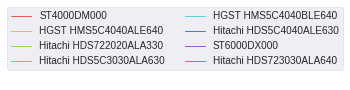

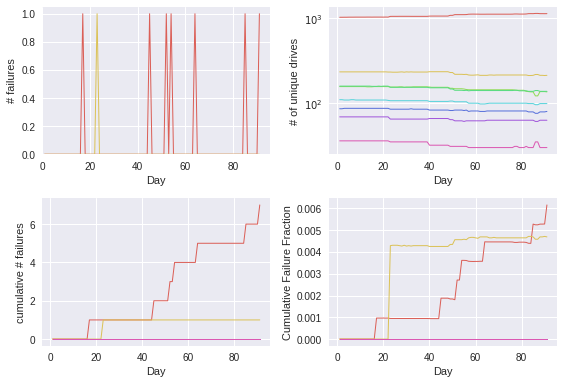

In [13]:

sn_colors = sns.color_palette("hls", 8)
tmark=""
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111)
for tcolor, umn in zip(sn_colors, range(len(models))):
    ax.plot([None], [None], marker=tmark, color=tcolor, lw=1.0,label = models[umn])
leg = plt.legend(loc='center', shadow=False, frameon=True, ncol=2, borderaxespad=0.)
leg.get_frame().set_linewidth(0.5)
plt.axis('off')
plt.show()

fig = plt.figure(figsize=(6,6))
fig = plt.figure()
ax = fig.add_subplot(221)
for tcolor, umn, in zip(sn_colors, range(len(models))):
    ax.plot(hd_by_model_by_day[umn].index, hd_by_model_by_day[umn].failure, marker=tmark, color=tcolor, lw=1.0)
ax.set_xlabel('Day')
ax.set_ylabel('# failures')
ax.set_xlim(0)
ax.set_ylim(0)
ax = fig.add_subplot(222)
for tcolor, umn in zip(sn_colors, range(len(models))):
    ax.semilogy(hd_by_model_by_day[umn].index, hd_by_model_by_day[umn].unique_serial, marker=tmark, color=tcolor, lw=1.0)
ax.set_xlabel('Day')
ax.set_ylabel('# of unique drives')
ax = fig.add_subplot(223)
for tcolor, umn in zip(sn_colors, range(len(models))):
    ax.plot(hd_by_model_by_day[umn].index, tot_failures[umn], marker=tmark, color=tcolor, lw=1.0)
ax.set_xlabel('Day')
ax.set_ylabel('cumulative # failures')
ax = fig.add_subplot(224)
for tcolor, umn in zip(sn_colors, range(len(models))):
    ax.plot(hd_by_model_by_day[umn].index, tot_failures[umn]/hd_by_model_by_day[umn].unique_serial, marker=tmark, color=tcolor, lw=1.0)
ax.set_xlabel('Day')
ax.set_ylabel('Cumulative Failure Fraction')
plt.tight_layout()
plt.show()


# What is the median survival time of a hard drive?
* Survival analysis for this, in particular the [lifelines package](http://lifelines.readthedocs.io/en/latest/). Note that this data is truncated and censored, what that means is that we need to use careful statistics to predict reasonable survival times and reasonable confidence levels of those predictions.

In [14]:
model_map = dict(zip(hd_models.index.tolist(),range(len(hd_models)))) # map the model names to integers for convenience
hd = hd.replace({'model': model_map})
print(model_map)

{'HGST HDS5C4040ALE630': 0, 'HGST HDS724040ALE640': 1, 'HGST HMS5C4040ALE640': 2, 'HGST HMS5C4040BLE640': 3, 'HGST HUH728080ALE600': 4, 'Hitachi HDS5C3030ALA630': 5, 'Hitachi HDS5C3030BLE630': 6, 'Hitachi HDS5C4040ALE630': 7, 'Hitachi HDS722020ALA330': 8, 'Hitachi HDS723020BLA642': 9, 'Hitachi HDS723030ALA640': 10, 'Hitachi HDS724040ALE640': 11, 'ST2000VN000': 12, 'ST31500541AS': 13, 'ST3160316AS': 14, 'ST3160318AS': 15, 'ST320LT007': 16, 'ST4000DM000': 17, 'ST4000DX000': 18, 'ST500LM012 HN': 19, 'ST6000DX000': 20, 'ST9250315AS': 21, 'ST9320325AS': 22, 'TOSHIBA DT01ACA300': 23, 'TOSHIBA MD04ABA400V': 24, 'TOSHIBA MD04ABA500V': 25, 'WDC WD10EACS': 26, 'WDC WD10EADS': 27, 'WDC WD10EADX': 28, 'WDC WD1600AAJS': 29, 'WDC WD20EFRX': 30, 'WDC WD30EFRX': 31, 'WDC WD3200AAJB': 32, 'WDC WD40EFRX': 33, 'WDC WD5000LPVX': 34, 'WDC WD60EFRX': 35, 'WDC WD800AAJS': 36}


In [15]:
#seagates = pd.DataFrame.copy(hd[hd['model'] == 'ST4000DM000']) # selected the most common seagate model
aggregations = {
    'day_of_year': { 
        'first_date': 'min',  
        'last_date': 'max', 
        'uncensored_days': 'count',
        'days': lambda x: max(x) - min(x)  
    },
    'smart_9_raw': { # smart 9 is the disk uptime
        'runtime_max': 'max',  
        'runtime_min': 'min',
        'uptime': lambda x: max(x) - min(x)  
    },
    'model':{
       'model_count': 'count',
       'model': 'mean'
    },
    'failure': {
     'failure': 'sum'
    }  
}
survival = hd.groupby('serial_number').agg(aggregations).reset_index()
survival.columns = survival.columns.droplevel()

In [16]:
survival = survival.loc[survival['failure'] <=1 ] # fi the sum of failures is gt 1 then then the data is bad
survival['runtime_max'] = survival['runtime_max']/8760.0 # hrs to yrs
survival['runtime_min'] = survival['runtime_min']/8760.0
print(survival['model'].value_counts())
del survival['model_count']

17    1552
2      298
5      190
8      190
3      130
7      112
20      87
10      43
31      34
19      21
34      15
35      13
13      13
18      10
27      10
24       9
29       6
30       5
0        5
25       4
15       4
22       3
21       3
26       2
23       2
14       2
33       1
12       1
4        1
6        1
16       1
32       1
11       1
9        1
28       1
1        1
36       1
Name: model, dtype: int64


## Kaplan-Meier Modeling

 *    Kaplan-Meier is a non-parametric non-generalising maximum-likelihood estimate of the survival function, S(t), which is the probability of survival until time t.
 *   The data is left truncated: hard drives enter study interval at different times. So we use the 'entry' keyword (Did I interpret the lifelines documentation right?)
 *   If we had a parametric form of the survival function we could predict new unseen data and predict the relative impact on survival of various hard drive attributes...



In [19]:
import lifelines as sa
km = sa.KaplanMeierFitter()
km.fit(durations=survival['runtime_max'], event_observed=survival['failure'], entry=survival['runtime_min'])
S = km.survival_function_
ax = km.plot(title="Kaplan Meier fit", legend=False)
ax.annotate('half-life', color='black', xy=(0.01,0.5), xycoords='axes fraction', xytext=(10,4), textcoords='offset points')
ax.axhline(.5, ls='--', lw=1.0, color='black')
ax.set_ylim([0,1])
#ax.set_xlim([0,6])
plt.show()

AttributeError: '_process_plot_var_args' object has no attribute 'color_cycle'

## Hazard rates with Nelson-Aalen
 * The failure rate is the total number of failures within a population, divided by the total time expended by that population, during a particular measurement interval.
 * The hazard function or hazard rate is the failure rate calculated instantaneously.  
 * The cumulative hazard curve is a basic tool: it is the sum of failure rate estimates so it is much more stable than the point-wise instananeous estimates.
 * The hazard curve has a catch: the derivation involves a smoothing kernel smoother applied to the differences of the cumulative hazard curve), and thus it has a free parameter.

In [20]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
seagate = survival.loc[survival['model'] == model_map['ST4000DM000']]
naf.fit(seagate['runtime_max'], seagate['failure'], entry=seagate['runtime_min'], label='Seagate ST4000DM000')
fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, sharex=True, sharey=True)
naf.plot(ax=axes[0,0],title="Cumulative Hazard Rate")
plt.show()

haz = naf.smoothed_hazard_
smoothing_bandwidth_time=1.2
q = haz(smoothing_bandwidth_time)
mean_haz = np.mean( q[q.columns[0]])

ax = naf.plot_hazard(bandwidth=smoothing_bandwidth_time, title = "Hazard Rate")
ax.axhline(mean_haz , ls='--', lw=1.0, color='black')
haz_str = str(100*np.round(mean_haz,4)) + "%"
ax.annotate(haz_str, color='black', xy=(0.01,mean_haz), xytext=(10,4), textcoords='offset points')
plt.show()
print("The failure rate for these seagate drives is %s" % haz_str)

AttributeError: '_process_plot_var_args' object has no attribute 'color_cycle'

### That was a lot of work to get basically the same failure rate that we calculated all the way back at the begining. Further survival regression analyis would be useful, but lets move on from survival analysis for now and ask another question.

##  Predict which hard drives will fail given the hard drive statistics?
 * So there isn't a lot of information about drive failures, but can we at least find what hard drive diagnostics (the smart values) are preddictive of a hard drive failure?
 * Most of the data columns are S.M.A.R.T. values that can vary in meaning based on the manufacturer and model. For this reason at this time limit the more in depth analysis to the most common identical drive model. 

In [22]:
#seagates = pd.DataFrame.copy(hd[hd['model'] == 'ST4000DM000']) # select only the most common seagate model
print(np.shape(hd))
# Some columns have just a few NaNs, while others are all NaNs
# drop columns of all nan
hd_clean = hd.dropna(axis=1, how='all')
# but lets avoid losing columns that potentially have lots of information
# in particular if the fraction of nans is greater than nan_frac, then drop
nan_frac = .3
for ikey in hd_clean.keys():
    tmp = hd_clean[ikey].isnull().sum()
    print(ikey, " has a NaN fraction of:\t", tmp/len(hd_clean))
    if tmp/len(hd_clean) >= nan_frac:
        hdcl = hd_clean.drop(ikey, 1)

# put zeros in the NaN locations we kept
hd_clean = hd_clean.fillna(0)

for ikey in hd_clean.keys():
    tmp = hd_clean[ikey].isnull().sum()
    if tmp > 0:
        print("Warning, there shouldn't be any NaNs but there are in %s" % ikey)

y = hd_clean.failure
print(np.shape(hd_clean))
print(hd_clean.columns)

(182000, 96)
capacity_tb  has a NaN fraction of:	 0.0
day_of_year  has a NaN fraction of:	 0.0
failure  has a NaN fraction of:	 0.0
model  has a NaN fraction of:	 0.0
serial_number  has a NaN fraction of:	 0.0
smart_10_normalized  has a NaN fraction of:	 0.0
smart_10_raw  has a NaN fraction of:	 0.0
smart_11_normalized  has a NaN fraction of:	 0.967373626374
smart_11_raw  has a NaN fraction of:	 0.967373626374
smart_12_normalized  has a NaN fraction of:	 0.0
smart_12_raw  has a NaN fraction of:	 0.0
smart_183_normalized  has a NaN fraction of:	 0.416697802198
smart_183_raw  has a NaN fraction of:	 0.416697802198
smart_184_normalized  has a NaN fraction of:	 0.413450549451
smart_184_raw  has a NaN fraction of:	 0.413450549451
smart_187_normalized  has a NaN fraction of:	 0.413450549451
smart_187_raw  has a NaN fraction of:	 0.413450549451
smart_188_normalized  has a NaN fraction of:	 0.413450549451
smart_188_raw  has a NaN fraction of:	 0.413450549451
smart_189_normalized  has a NaN fra

### Get just the "raw" columns

In [24]:
def clip_by_column_txt(df, col_txt):
    for ikey in df.keys():
        if col_txt not in ikey:
            del df[ikey]

clip_by_column_txt(hd_clean,"raw") # select raw columns only

print(np.shape(hd_clean))
print(hd_clean.columns)
#sel = VarianceThreshold(threshold=.01)  # remove the features with variance below threshold.
#sel.fit_transform(hd)
#print(hdcl.head(3))

(182000, 41)
Index(['smart_10_raw', 'smart_11_raw', 'smart_12_raw', 'smart_183_raw',
       'smart_184_raw', 'smart_187_raw', 'smart_188_raw', 'smart_189_raw',
       'smart_190_raw', 'smart_191_raw', 'smart_192_raw', 'smart_193_raw',
       'smart_194_raw', 'smart_195_raw', 'smart_196_raw', 'smart_197_raw',
       'smart_198_raw', 'smart_199_raw', 'smart_1_raw', 'smart_200_raw',
       'smart_220_raw', 'smart_222_raw', 'smart_223_raw', 'smart_224_raw',
       'smart_225_raw', 'smart_226_raw', 'smart_22_raw', 'smart_240_raw',
       'smart_241_raw', 'smart_242_raw', 'smart_250_raw', 'smart_251_raw',
       'smart_252_raw', 'smart_254_raw', 'smart_2_raw', 'smart_3_raw',
       'smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_8_raw',
       'smart_9_raw'],
      dtype='object')


### There are a few ways you could decide to clip the important features... 

In [ ]:
# Use forest classifier to find important features
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(hd_clean, y)
importance = forest.feature_importances_
std_err = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# get the indices and sort the labels of the important features
indices = np.argsort(importance)[::-1]
#print(hdcl.columns[indices])
x_labels = hd_clean.columns[indices]
x_labels = x_labels[indices]
importance = importance[indices]
std_err = std_err[indices]
#x_labels = [x for (y, x) in sorted(zip(importance, hdcl.columns))][::-1]

In [ ]:
print("Feature ranking:")
for f in range(hd_clean.shape[1]):
    print("Rank %d: %s (%f)" % (f + 1, x_labels[f], importance[f]))

### In the plot the dashed line is the median of the importance which is the chosen threshold.

In [ ]:
# clip the features to the most important ones
thresh = np.median(importance)
clip_importance = importance[np.where(importance >= thresh)]
clip_std_err = std_err[np.where(importance >= thresh)]
clip_x_labels = x_labels[np.where(importance >= thresh)]
clip_l = len(clip_importance)
#for i in range(len(clip_indices)):
#    print("%d. clipped feature %s (%f)" % (i + 1, clip_x_labels[i], clip_importance[i]))
sn_colors = sns.color_palette()
plt.figure()
plt.title("Feature Importances")
plt.bar(range(clip_l), clip_importance, color=sn_colors[1],
        yerr=clip_std_err, align="center")
# Plot the mean line, below using SelectFromModel we will clip features below this value
plt.axhline(thresh, ls='--', lw=2.0, color='black', alpha=99)
plt.xticks(range(clip_l), clip_x_labels, rotation=80)
plt.xlim([-1, clip_l])
plt.ylim([0, .5])
plt.show()